### 0. Imports and Formatters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys; sys.path.insert(0, '..')
import packages.formatter as fmt
fmt.init_formatters()

### 1. Density matrix

In [3]:
p_0 = 0.5
psi_1 = np.array([1, 1j, -1, 0, 2]) / np.sqrt(7)
psi_2 = np.array([1, 1, 1, 1, 1]) / np.sqrt(5)
rho = p_0 * np.outer(psi_1, np.conj(psi_1)) + (1 - p_0) * np.outer(psi_2, np.conj(psi_2))
rho

array([[ 0.17142857+0.j        ,  0.1       -0.07142857j,
         0.02857143+0.j        ,  0.1       +0.j        ,
         0.24285714+0.j        ],
       [ 0.1       +0.07142857j,  0.17142857+0.j        ,
         0.1       -0.07142857j,  0.1       +0.j        ,
         0.1       +0.14285714j],
       [ 0.02857143+0.j        ,  0.1       +0.07142857j,
         0.17142857+0.j        ,  0.1       +0.j        ,
        -0.04285714+0.j        ],
       [ 0.1       +0.j        ,  0.1       +0.j        ,
         0.1       +0.j        ,  0.1       +0.j        ,
         0.1       +0.j        ],
       [ 0.24285714+0.j        ,  0.1       -0.14285714j,
        -0.04285714+0.j        ,  0.1       +0.j        ,
         0.38571429+0.j        ]])

### 2. Trace

In [4]:
np.trace(rho)

(0.9999999999999998+0j)

In [5]:
np.trace(rho @ rho)

(0.5714285714285712-8.425799740458774e-19j)

In [6]:
H = np.diag([j * (j - 1) for j in range(5)])
np.trace(H @ rho)

(5.57142857142857+0j)

### 3. Eigenvalues

In [7]:
p_k = np.linalg.eigvals(rho)
p_k

array([ 6.88982237e-01-4.48813147e-17j, -7.83747137e-17-1.29992561e-17j,
        3.11017763e-01+3.01249951e-17j,  1.73338906e-17-1.06010784e-19j,
       -8.31707831e-19-2.64429964e-18j])

In [8]:
S = -np.sum(p_k * np.log(p_k))
S

(0.6199125767729554-7.944677108193761e-16j)

### 4. Canonical Density matrix

In [9]:
def rho_k(T):
    exp = np.exp(-H / T)
    Z = np.trace(exp)
    return exp / Z

def E(T):
    rho = rho_k(T)
    return np.trace(H @ rho)

def S(T):
    rho = rho_k(T)
    return -np.trace(rho @ np.log(rho))

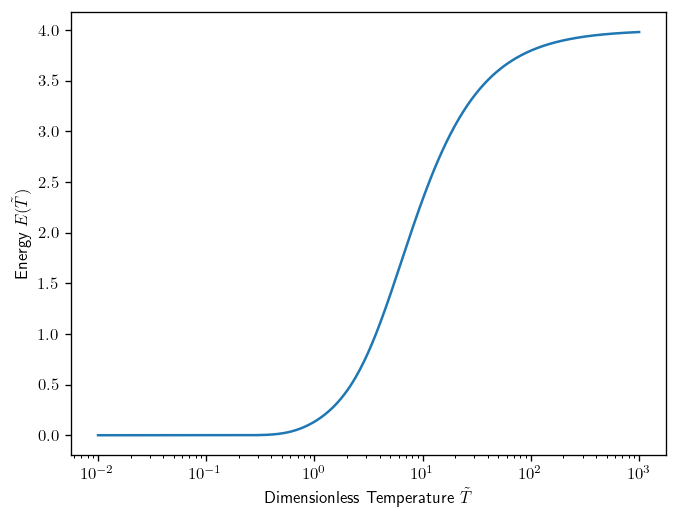

In [10]:
T = np.logspace(-2, 3, 400)
E_vals = np.array([E(t) for t in T])
plt.plot(T, E_vals)
plt.xscale('log')
plt.xlabel(r"Dimensionless Temperature $\tilde{T}$")
plt.ylabel(r"Energy $E(\tilde{T})$")
plt.show()

C:\Users\nicol\AppData\Local\Temp\ipykernel_25012\1283499653.py:12: RuntimeWarning: divide by zero encountered in log
  return -np.trace(rho @ np.log(rho))
C:\Users\nicol\AppData\Local\Temp\ipykernel_25012\1283499653.py:12: RuntimeWarning: invalid value encountered in matmul
  return -np.trace(rho @ np.log(rho))


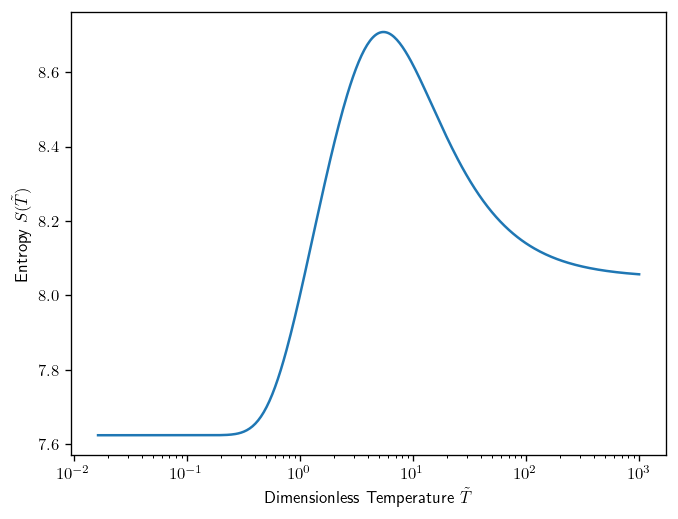

In [11]:
T = np.logspace(-2, 3, 400)
S_vals = np.array([S(t) for t in T])
plt.plot(T, S_vals)
plt.xscale('log')
plt.xlabel(r"Dimensionless Temperature $\tilde{T}$")
plt.ylabel(r"Entropy $S(\tilde{T})$")
plt.show()